# Analysis of CBRAIN-CAM online runs

Goal: Get a standard set of analysis for online runs and compare to reference runs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML, FileLink

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DATA_DIR = '/beegfs/DATA/pritchard/srasp/'
%ls {DATA_DIR}

nnatmonly_fbp8_D002_andkua/         nnfullphy_std8_A003/  sp32fbp_andkua/
nnatmonly_fbp8_D003_andkua/         nonsp_3kw1/           sp8fbp_3kw1/
nnatmonly_fbp8_D004_andkua_allfix/  nonsp_4k/             sp8fbp_4k/
nnatmonly_fbp8_D004_andkua_msefix/  nonsp_andkua/         sp8fbp_andkua/
nnatmonly_fbp8_D004_andkua_qfix/    old_3kw1/             tmp/
nnfullphy_fbp32_E002_andkua/        old_data/
nnfullphy_fbp8_E001_andkua/         preprocessed_data/


In [4]:
exps_andkua= ['sp8fbp_andkua', 'nnfullphy_fbp8_E001_andkua', 'nnatmonly_fbp8_D002_andkua', 
              'nnatmonly_fbp8_D003_andkua', 'nnatmonly_fbp8_D004_andkua_nofix', 
              'nnatmonly_fbp8_D004_andkua_qfix', 'nnatmonly_fbp8_D004_andkua_msefix', 
              'nnatmonly_fbp8_D004_andkua_allfix', 'nonsp_andkua']

In [5]:
exps_3kw1 = ['sp8fbp_3kw1', 'nnfullphy_fbp8_E001_3kw1', 'nnatmonly_fbp8_D002_3kw1', 'nonsp_3kw1']

In [6]:
exps_32 = ['sp32fbp_andkua', 'nnfullphy_fbp32_E002_andkua']

In [7]:
exps = exps_andkua + exps_3kw1 + exps_32

In [11]:
%%time
h0s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h0.0000-*', decode_times=False) for e in exps_andkua}

CPU times: user 17.2 s, sys: 70 ms, total: 17.3 s
Wall time: 17.7 s


In [43]:
%%time
h1s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h1.0000-*', decode_times=False) for e in exps_andkua}

CPU times: user 44.7 s, sys: 1.07 s, total: 45.7 s
Wall time: 8min 36s


In [12]:
def gw_avg(ds, var):
    return (ds[var] * ds['gw'].values.reshape(-1, 64, 1)).sum(dim=('lat', 'lon')) / 2

In [57]:
def vint_cut(ds, var, factor, cut=100):
    dP = get_dP_from_ds(ds)
    x = ds[var]
    dP['lev'] = x['lev']
    return (dP * x * factor / G).sel(lev=slice(cut, None)).sum(dim='lev')

In [58]:
for d in h0s.values(): 
    d['vTAP'] = vint(d, 'TAP', C_P); d['vQAP'] = vint(d, 'QAP', L_V)
    d['vTAPcut'] = vint_cut(d, 'TAP', C_P); d['vQAPcut'] = vint_cut(d, 'QAP', L_V)
    d['vTPHY'] = vint(d, 'TPHYSTND', C_P); d['vPHQ'] = vint(d, 'PHQ', L_V)

In [14]:
def compare(func, exps, ref=None, title=None, **kwargs):
    npanels = len(exps) if ref is None else len(exps) + 1
    ncols=min(3, npanels); nrows=int(np.ceil(npanels/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4*nrows));
    if ref is None:
        [func(h0s[e]).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat)]
        [ax.set_title(e) for e, ax in zip(exps, axs.flat)]
    else:
        yi = kwargs['yincrease'] if 'yincrease' in kwargs.keys() else None
        func(h0s[ref]).plot(ax=axs.flat[0], yincrease=yi); axs.flat[0].set_title(ref)
        [(func(h0s[e])-func(h0s[ref]).values).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat[1:])]
        [ax.set_title(f'{e} - {ref}') for e, ax in zip(exps, axs.flat[1:])]
    if title is None: plt.tight_layout()
    else: fig.suptitle(title); plt.tight_layout(rect=(0, 0, 1, 0.95))
    return fig, axs

In [26]:
def compare_line(func, exps, ax=None, legend=True, **kwargs):
    if ax is None: fig, ax = plt.subplots(figsize=(6, 5))
    [func(h0s[e]).plot(ax=ax, label=e, **kwargs) for e in exps]
    if legend: ax.legend()

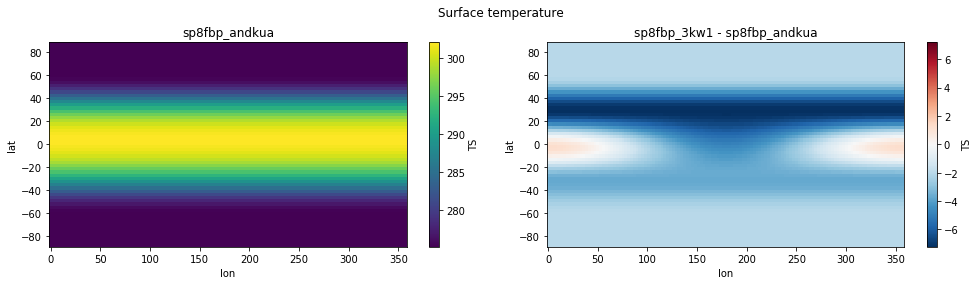

In [202]:
compare(lambda d: d['TS'].isel(time=0), [exps_3kw1[0]], ref = exps_andkua[0], title='Surface temperature')

## For Mike

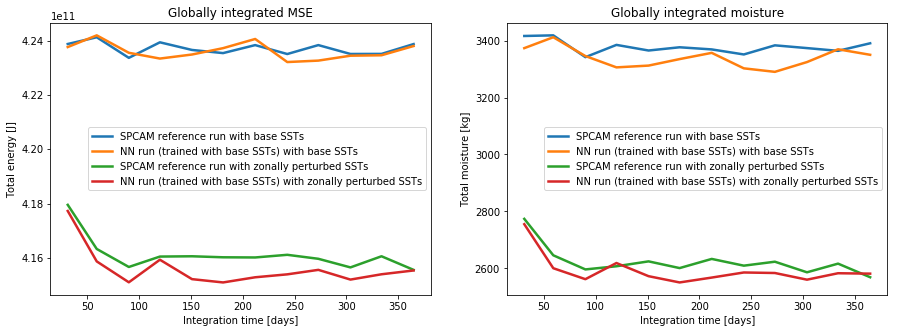

In [350]:
# Figure for Mike
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'TE'), ['sp8fbp_andkua', 'nnatmonly_fbp8_D002_andkua',
                                         'sp8fbp_3kw1', 'nnatmonly_fbp8_D002_3kw1'], ax=axs[0], lw=2.5)
compare_line(lambda d: gw_avg(d, 'TW'), ['sp8fbp_andkua', 'nnatmonly_fbp8_D002_andkua',
                                         'sp8fbp_3kw1', 'nnatmonly_fbp8_D002_3kw1'], ax=axs[1], lw=2.5)
axs[0].set_title('Globally integrated MSE'); axs[1].set_title('Globally integrated moisture')
axs[0].set_ylabel('Total energy [J]'); axs[1].set_ylabel('Total moisture [kg]')
[ax.set_xlabel('Integration time [days]') for ax in axs];
[ax.legend(['SPCAM reference run with base SSTs', 'NN run (trained with base SSTs) with base SSTs',
            'SPCAM reference run with zonally perturbed SSTs', 'NN run (trained with base SSTs) with zonally perturbed SSTs']) 
 for ax in axs];

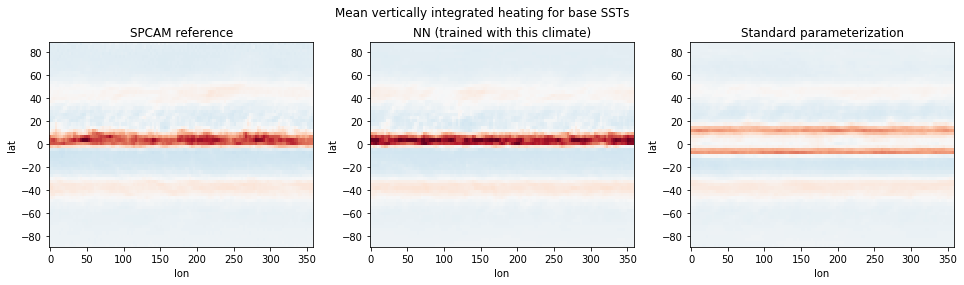

In [372]:
fig, axs = compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), 
        ['sp8fbp_andkua', 'nnatmonly_fbp8_D002_andkua', 'nonsp_andkua'],
        title='Mean vertically integrated heating for base SSTs', vmin=-500, vmax=500, cmap='RdBu_r', 
                   add_colorbar=False)
[ax.set_title(t) for ax, t in 
 zip(axs.flat, ['SPCAM reference', 'NN (trained with this climate)', 'Standard parameterization'])];

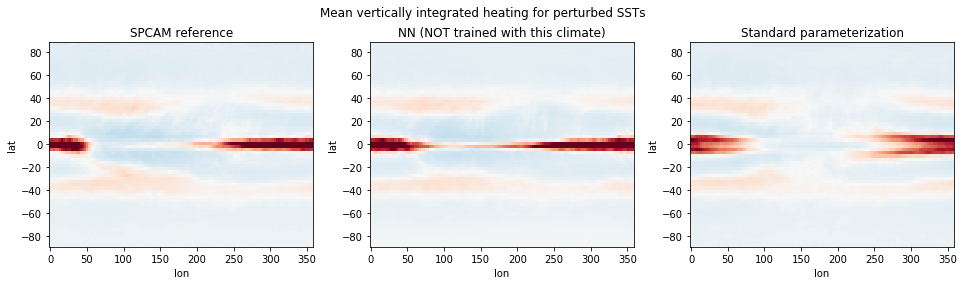

In [373]:
fig, axs = compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), 
        ['sp8fbp_3kw1', 'nnatmonly_fbp8_D002_3kw1', 'nonsp_3kw1'],
        title='Mean vertically integrated heating for perturbed SSTs', vmin=-500, vmax=500, cmap='RdBu_r', 
                   add_colorbar=False)
[ax.set_title(t) for ax, t in 
 zip(axs.flat, ['SPCAM reference', 'NN (NOT trained with this climate)', 'Standard parameterization'])];

## Global energetics

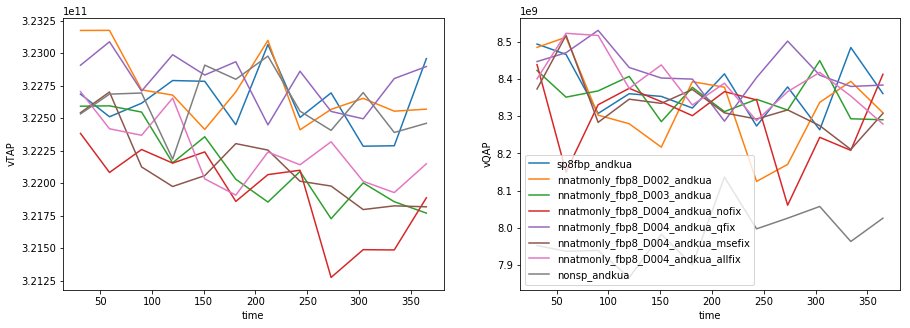

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'vTAP'), exps_andkua, legend=False, ax=axs[0])
compare_line(lambda d: gw_avg(d, 'vQAP'), exps_andkua, ax=axs[1])

In [29]:
exps_engy_ess = list(exps_andkua); exps_engy_ess.pop(1)

'nnatmonly_fbp8_D002_andkua'

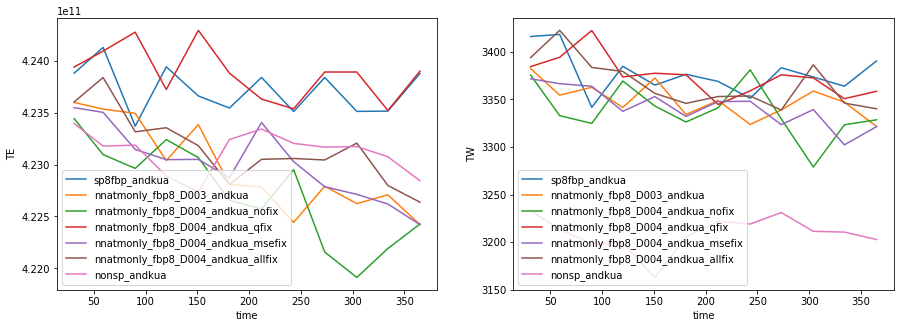

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
compare_line(lambda d: gw_avg(d, 'TE'), exps_engy_ess, ax=axs[0])
compare_line(lambda d: gw_avg(d, 'TW'), exps_engy_ess, ax=axs[1])

## Reference SST runs

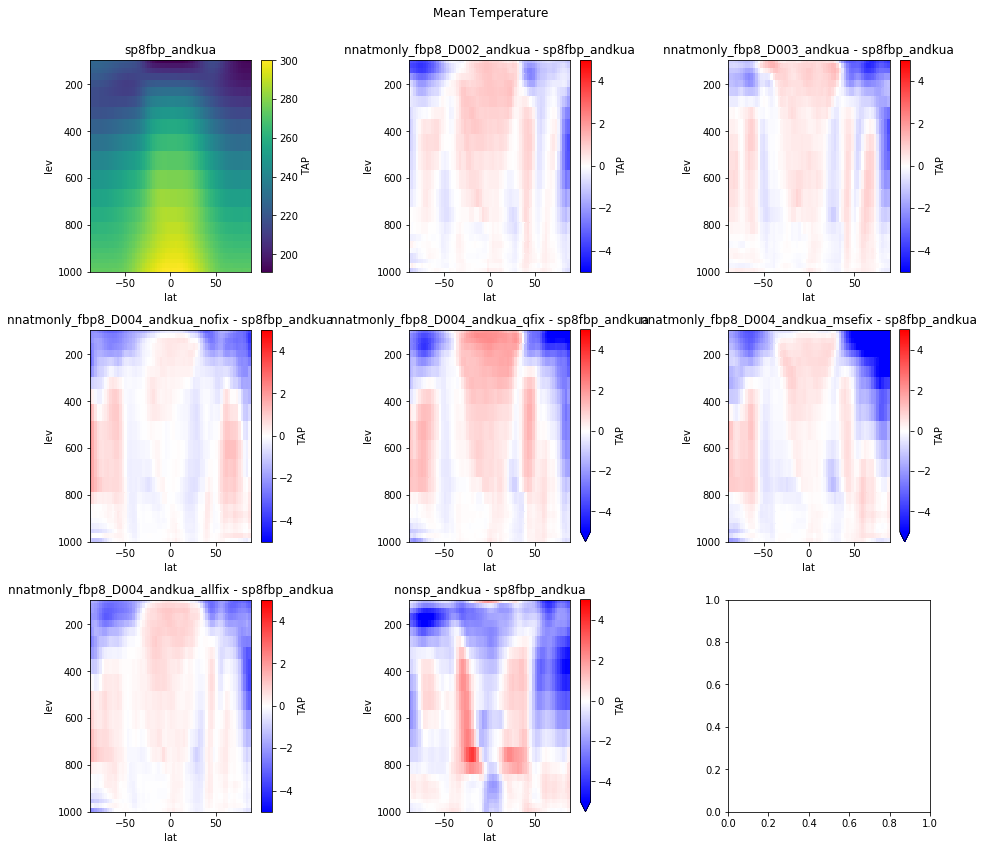

In [40]:
compare(lambda d: d['TAP'].sel(time=slice(30, None), lev=slice(100, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='bwr', title='Mean Temperature');

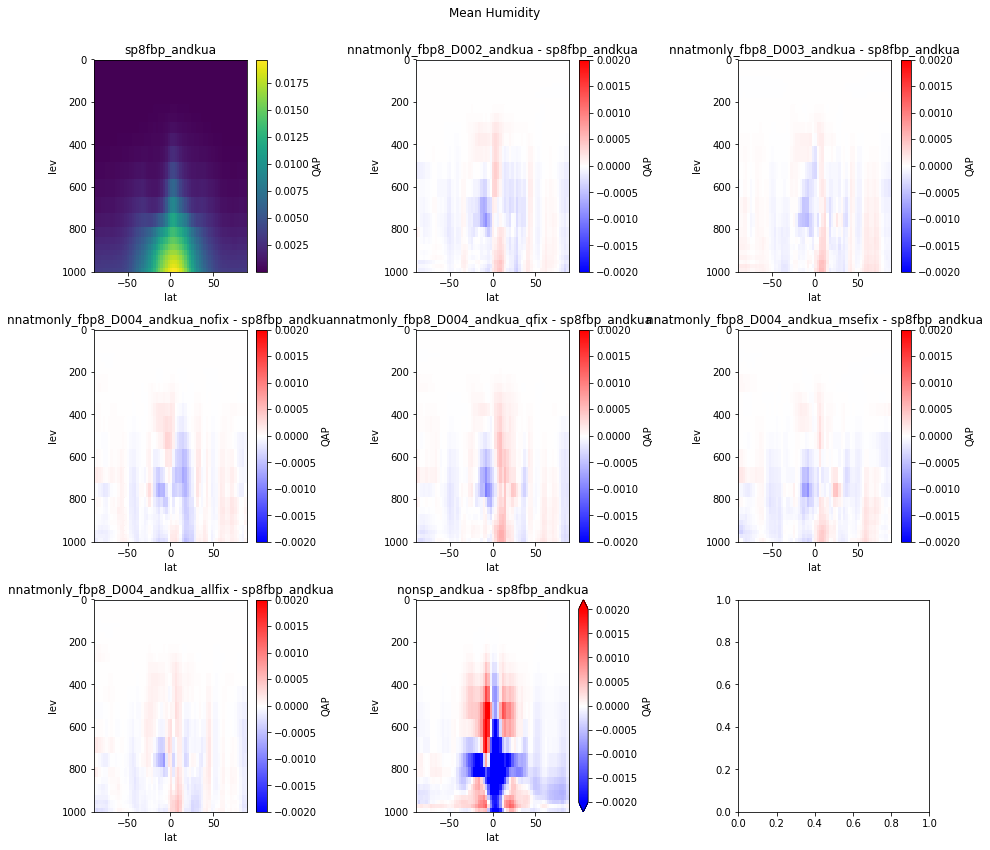

In [32]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, cmap='bwr', vmin=-0.002, vmax=0.002, title='Mean Humidity');

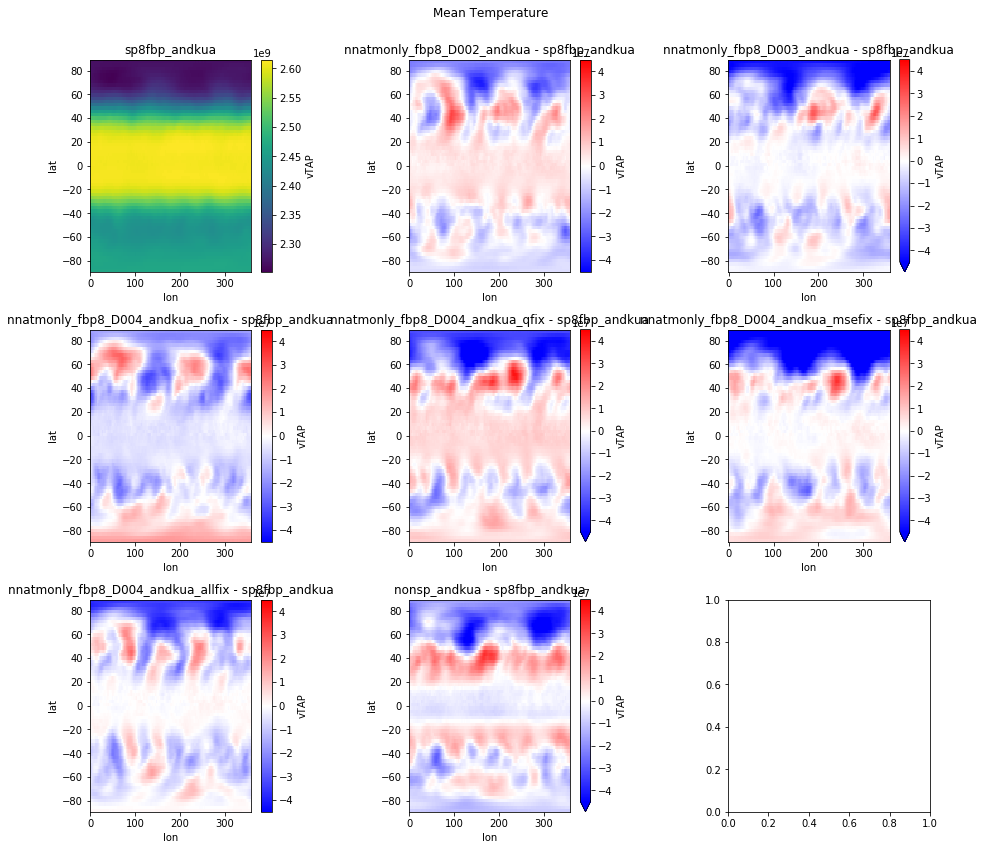

In [33]:
compare(lambda d: d['vTAP'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean Temperature', cmap='bwr', vmin=-4.5e7, vmax=4.5e7);

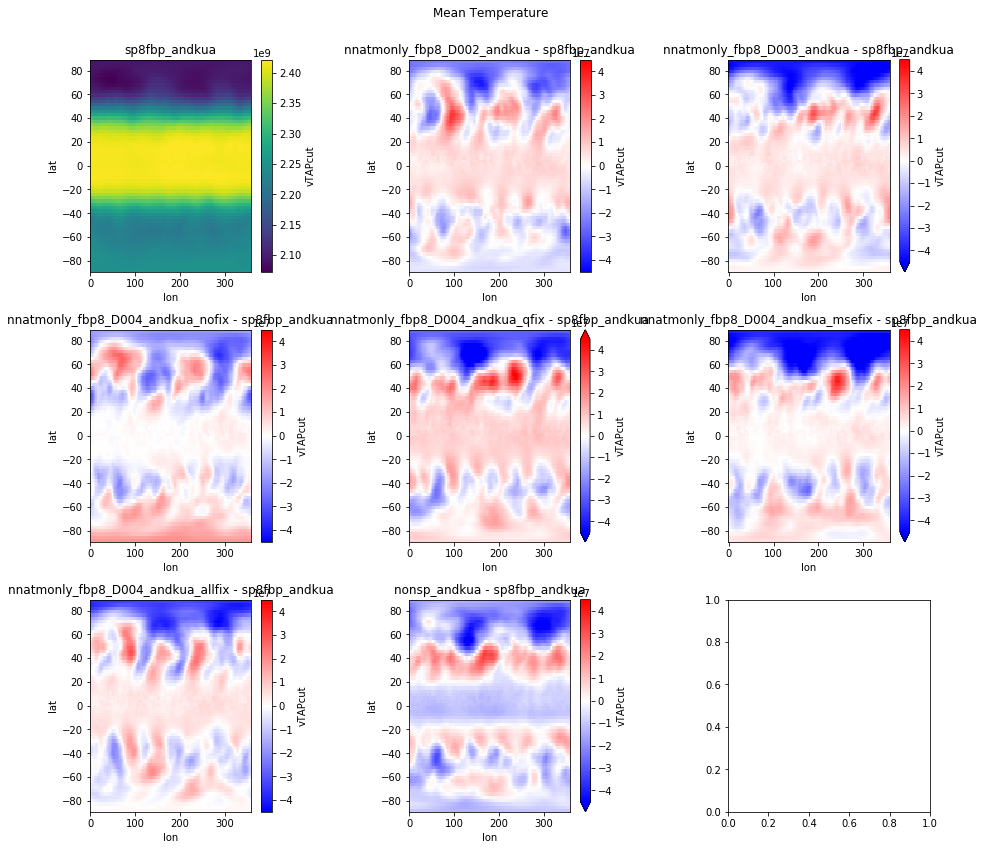

In [59]:
compare(lambda d: d['vTAPcut'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean Temperature', cmap='bwr', vmin=-4.5e7, vmax=4.5e7);

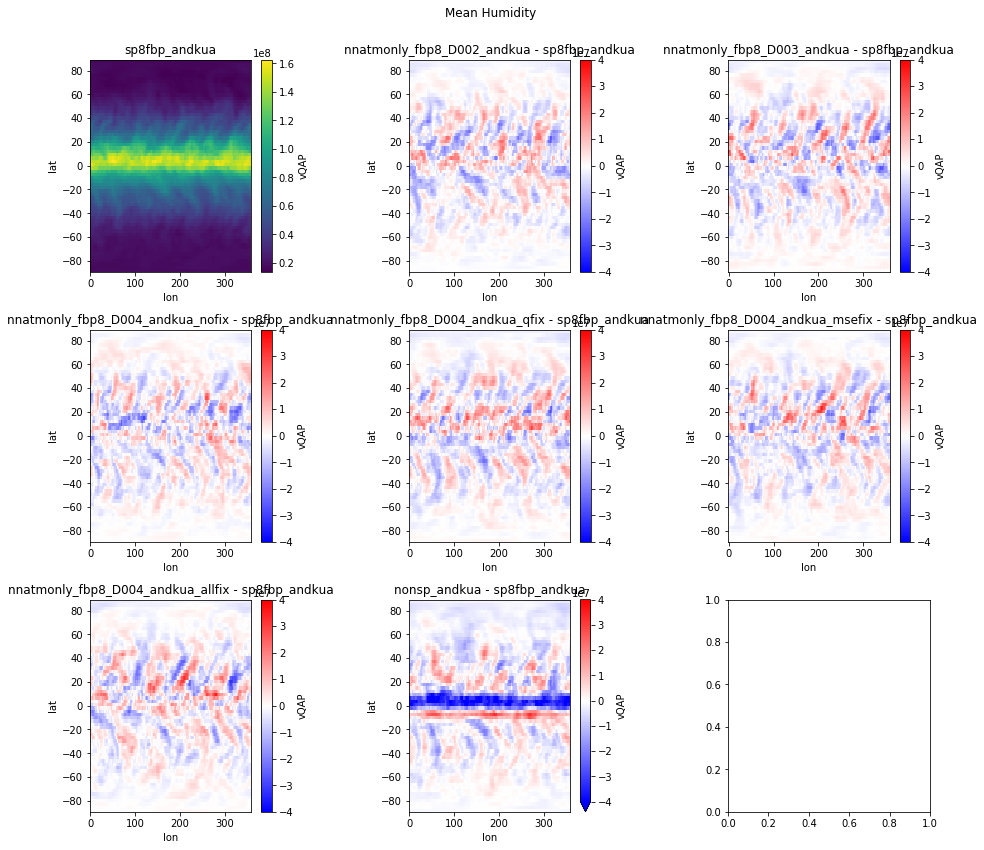

In [34]:
compare(lambda d: d['vQAP'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean Humidity', cmap='bwr', vmin=-4e7, vmax=4e7);

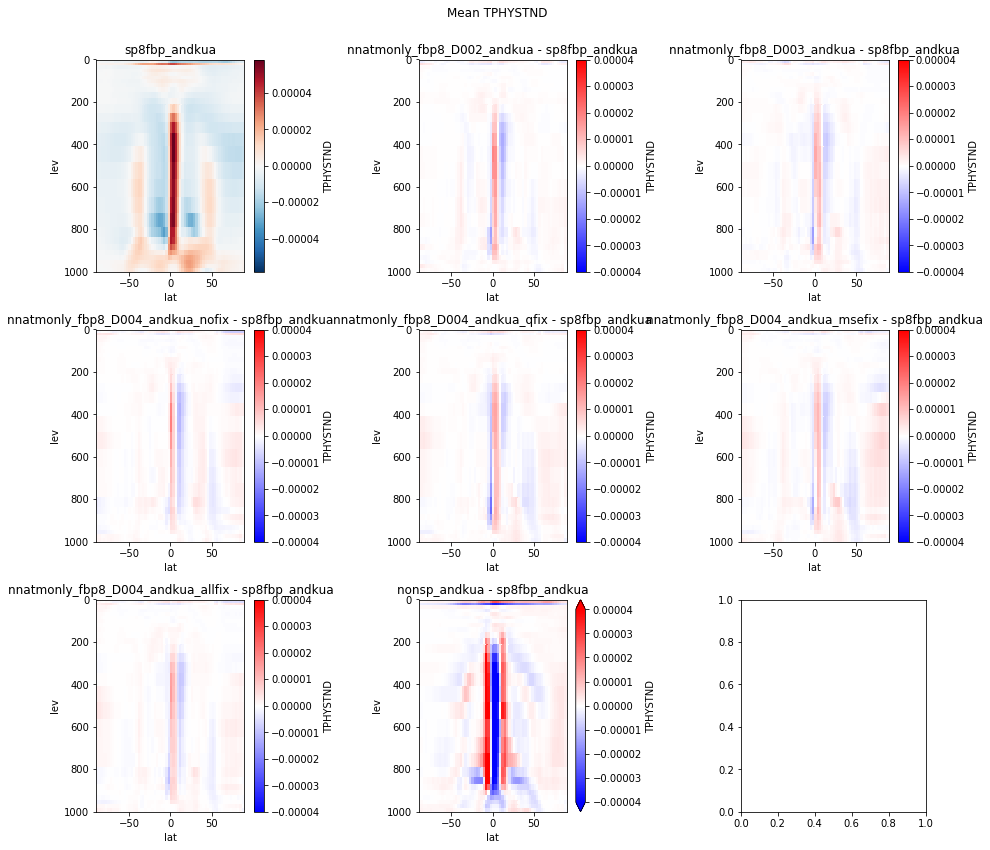

In [35]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, cmap='bwr', title='Mean TPHYSTND', vmin=-4e-5, vmax=4e-5);

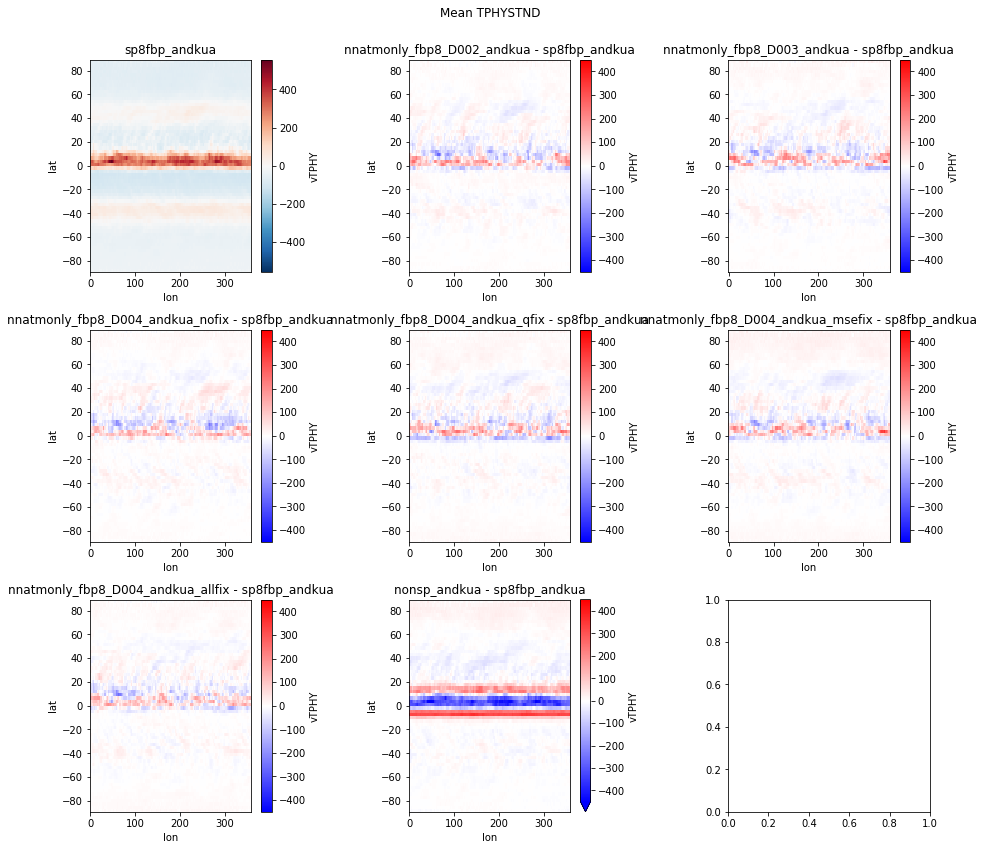

In [36]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean TPHYSTND', cmap='bwr', vmin=-450, vmax=450);

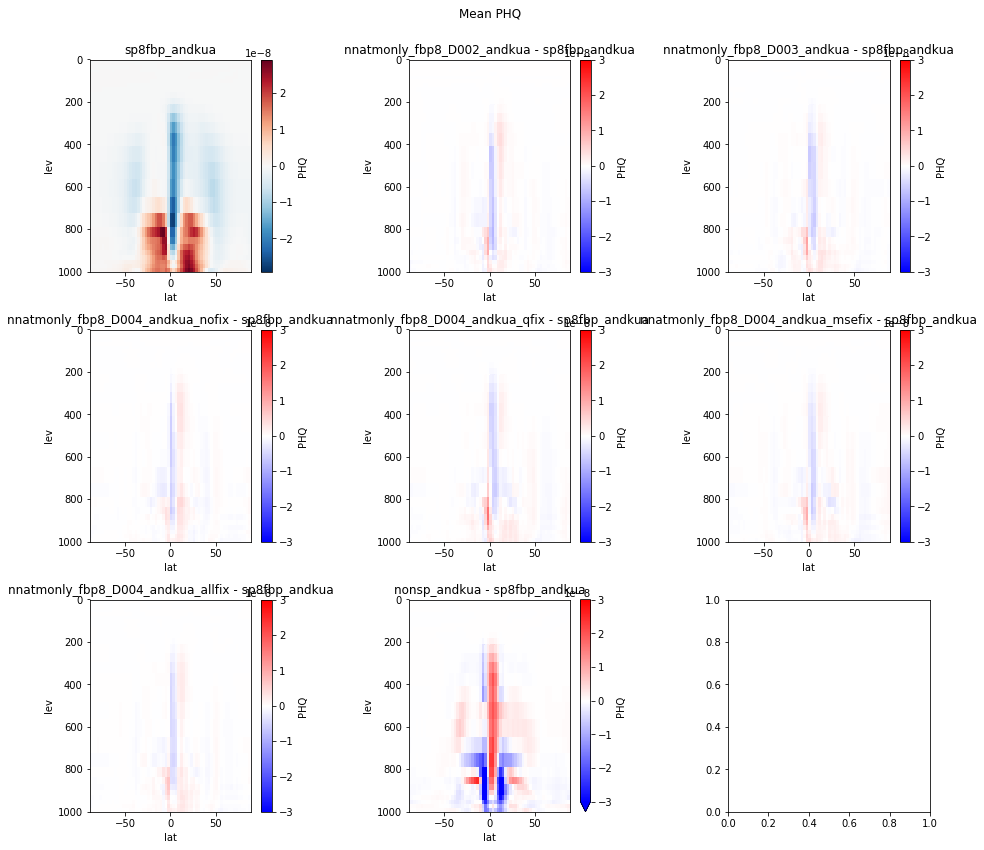

In [37]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_andkua[1:], ref=exps_andkua[0], 
        yincrease=False, cmap='bwr', title='Mean PHQ', vmin=-3e-8, vmax=3e-8);

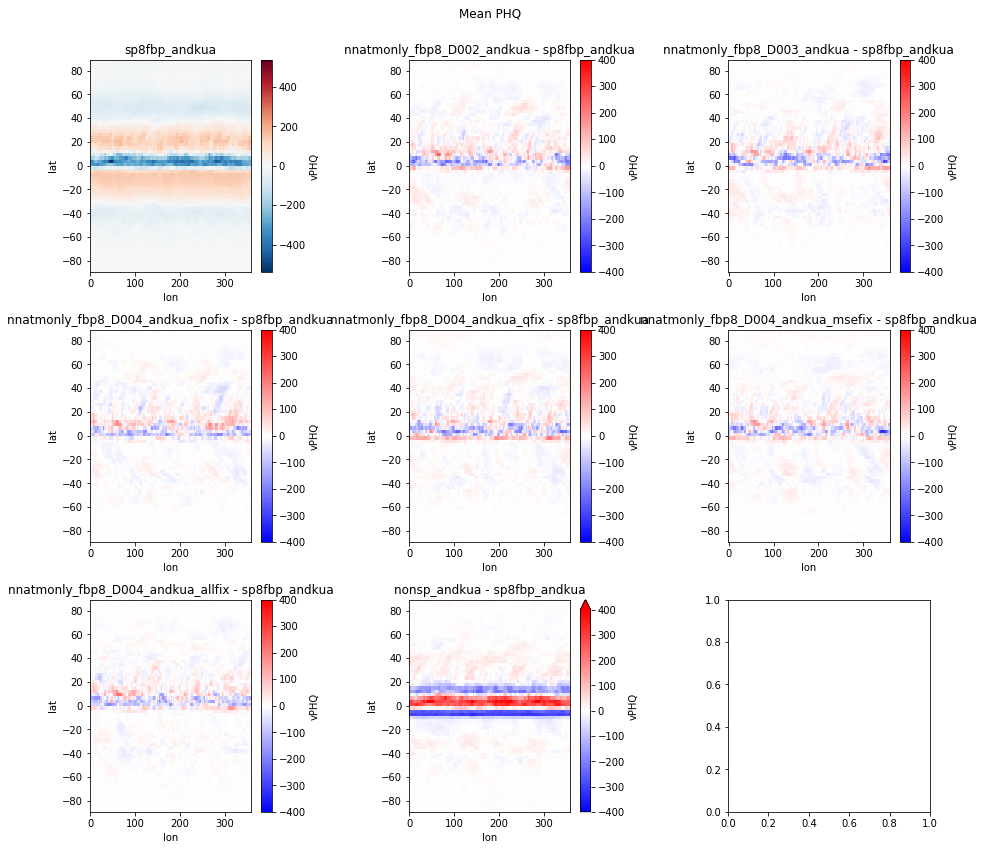

In [38]:
compare(lambda d: d['vPHQ'].sel(time=slice(30, None)).mean(('time')), exps_andkua[1:], ref=exps_andkua[0],
        title='Mean PHQ', cmap='bwr', vmin=-400, vmax=400);

In [42]:
h0s[exps_engy_ess[-2]]

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 12)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 31.0 59.0 90.0 120.0 151.0 181.0 212.0 ...
Dimensions wit

## Precipitation histograms

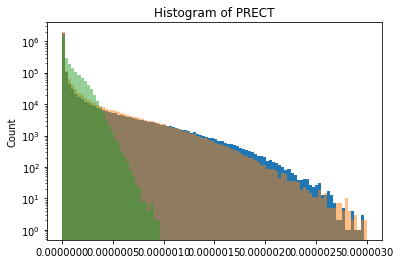

In [55]:
h1s[exps_engy_ess[-2]]['NNPRECT'].sel(time=slice(30, None), lat=slice(-20, 20)).plot(range=(0, 3e-6), bins=100)
h1s[exps_engy_ess[0]]['PRECT'].sel(time=slice(30, None), lat=slice(-20, 20)).plot(range=(0, 3e-6), bins=100, alpha=0.5);
h1s[exps_engy_ess[-1]]['PRECT'].sel(time=slice(30, None), lat=slice(-20, 20)).plot(range=(0, 3e-6), bins=100, alpha=0.5);
plt.yscale('log')

## 3KW1 Runs

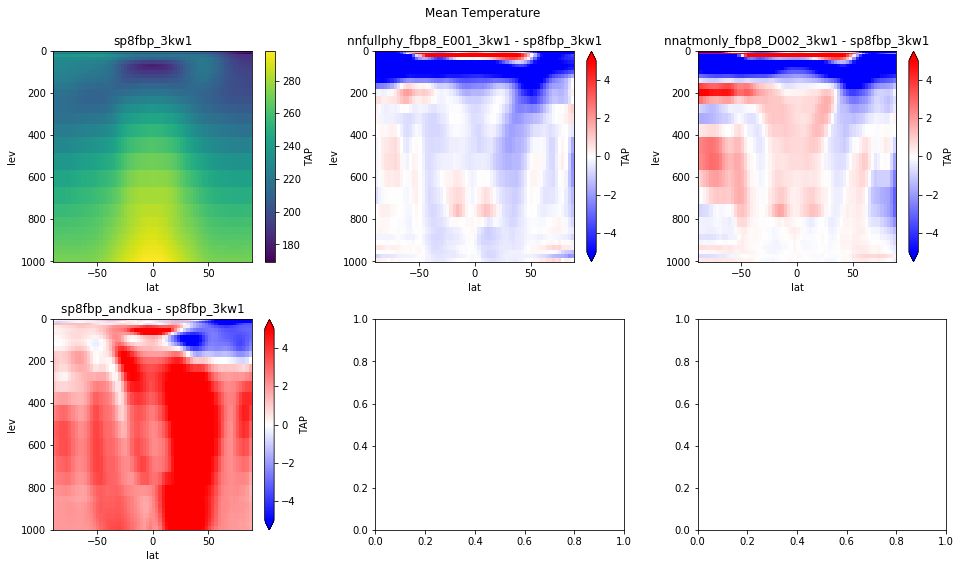

In [318]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='bwr', title='Mean Temperature')

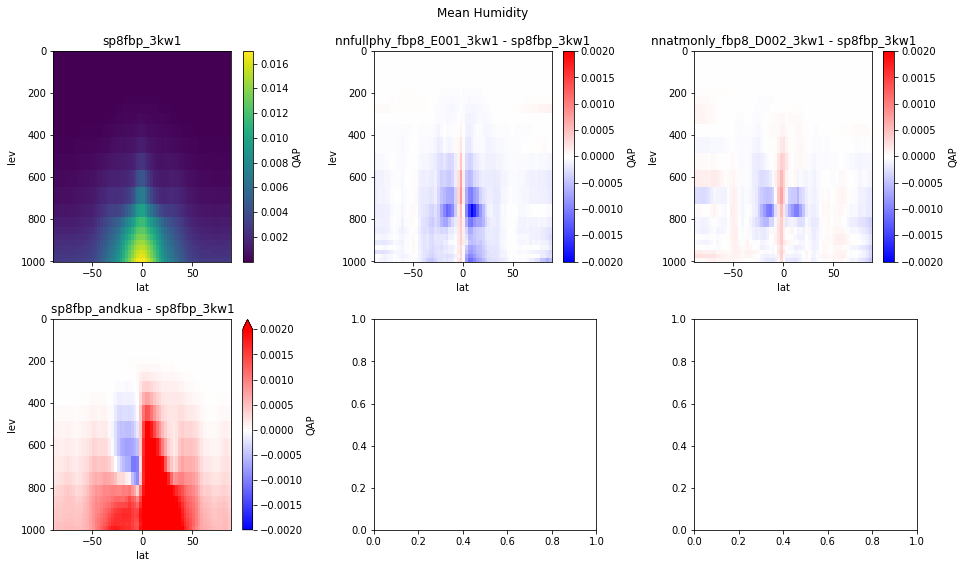

In [319]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0], 
        yincrease=False, cmap='bwr', vmin=-0.002, vmax=0.002, title='Mean Humidity')

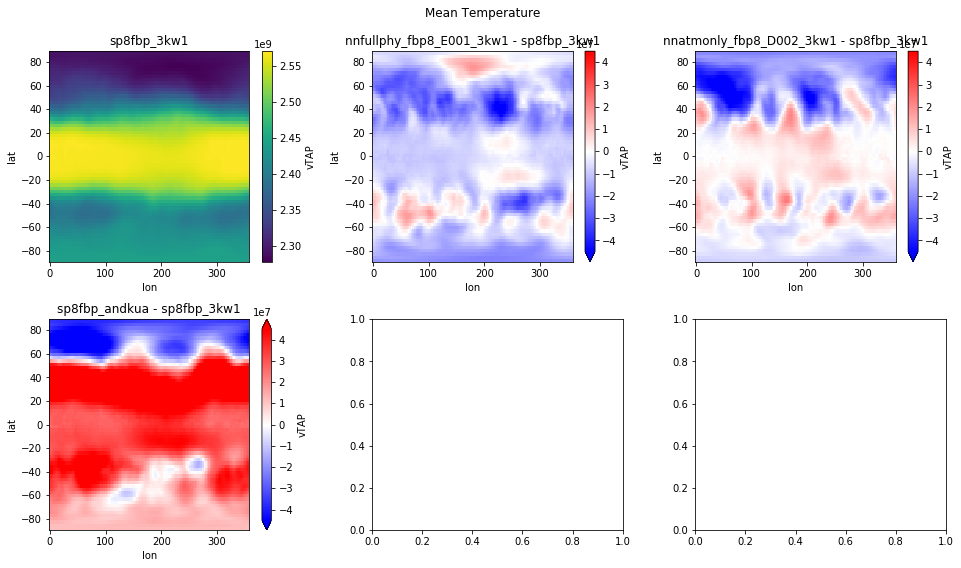

In [320]:
compare(lambda d: d['vTAP'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0],
        title='Mean Temperature', cmap='bwr', vmin=-4.5e7, vmax=4.5e7)

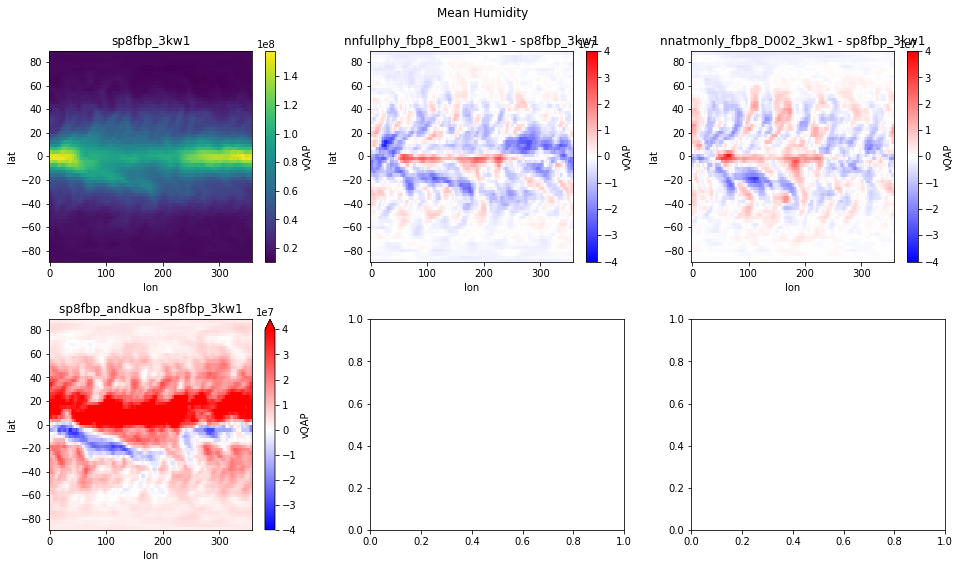

In [321]:
compare(lambda d: d['vQAP'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0],
        title='Mean Humidity', cmap='bwr', vmin=-4e7, vmax=4e7)

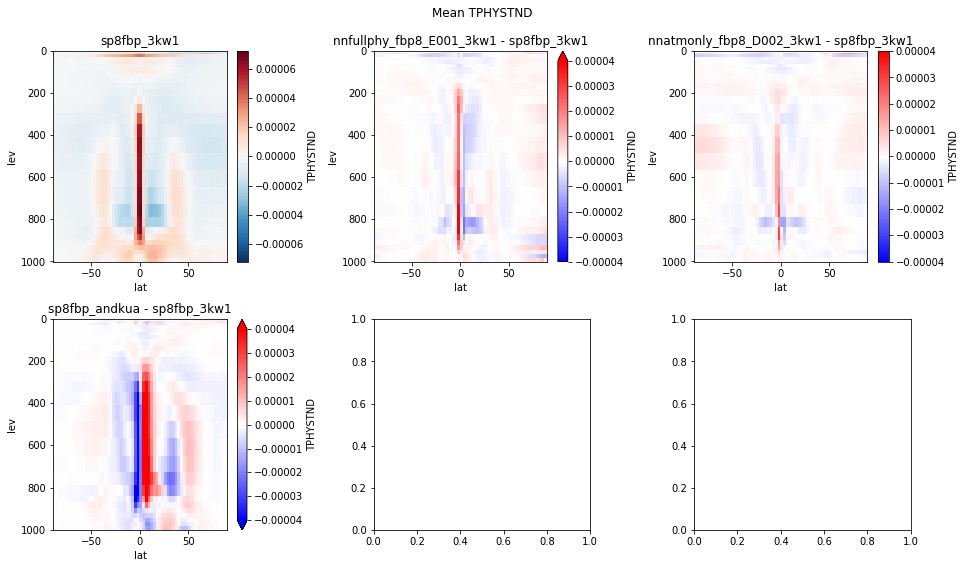

In [322]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0], 
        yincrease=False, cmap='bwr', title='Mean TPHYSTND', vmin=-4e-5, vmax=4e-5)

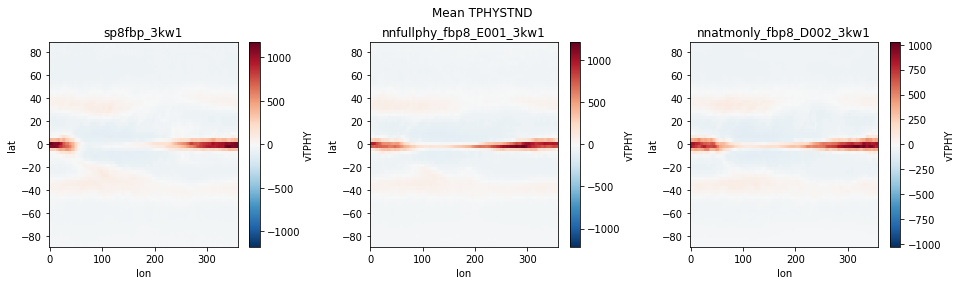

In [293]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_3kw1,
        title='Mean TPHYSTND')

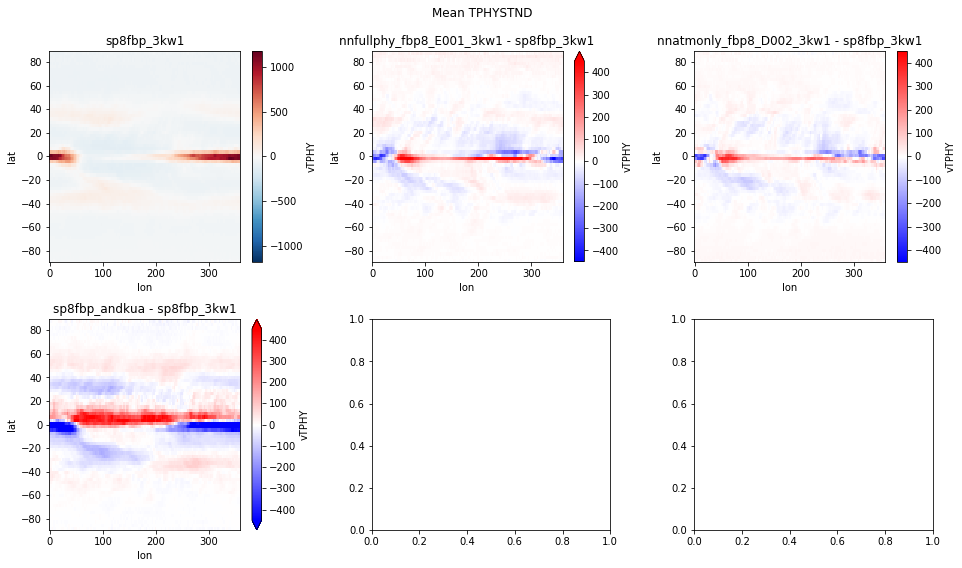

In [323]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:] + [exps_andkua[0]], ref=exps_3kw1[0],
        title='Mean TPHYSTND', cmap='bwr', vmin=-450, vmax=450)

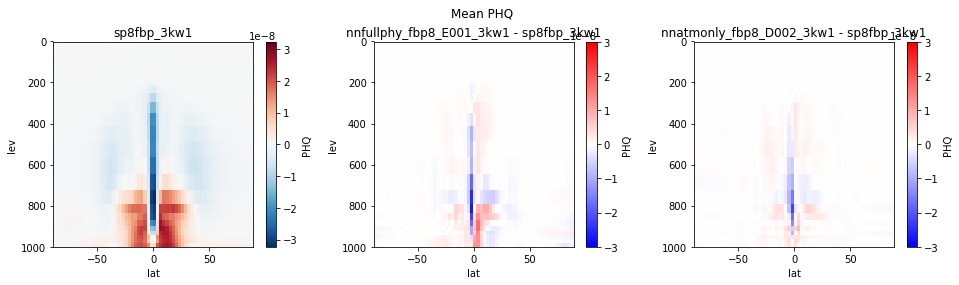

In [291]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), exps_3kw1[1:], ref=exps_3kw1[0], 
        yincrease=False, cmap='bwr', title='Mean PHQ', vmin=-3e-8, vmax=3e-8)

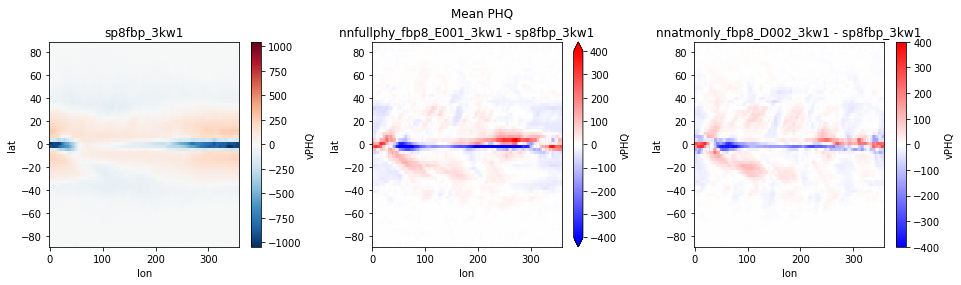

In [292]:
compare(lambda d: d['vPHQ'].sel(time=slice(30, None)).mean(('time')), exps_3kw1[1:], ref=exps_3kw1[0],
        title='Mean PHQ', cmap='bwr', vmin=-400, vmax=400)

## 8 vs 32 cols

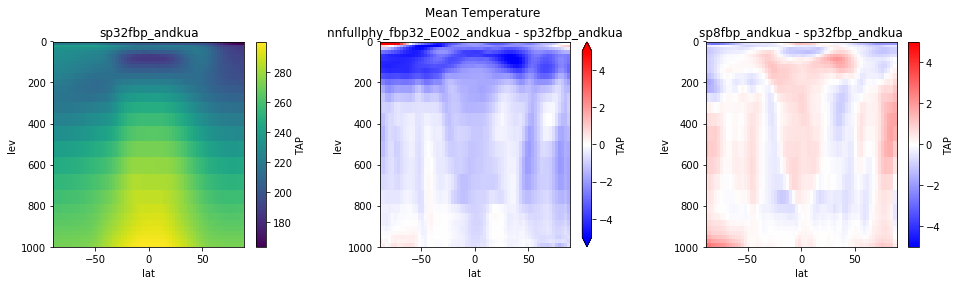

In [309]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='bwr', title='Mean Temperature')

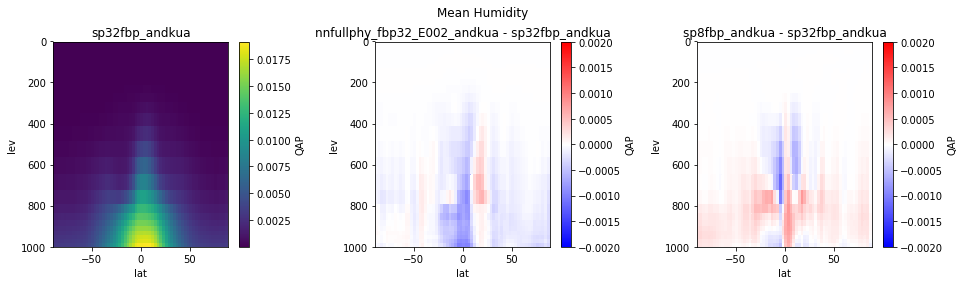

In [310]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, cmap='bwr', vmin=-0.002, vmax=0.002, title='Mean Humidity')

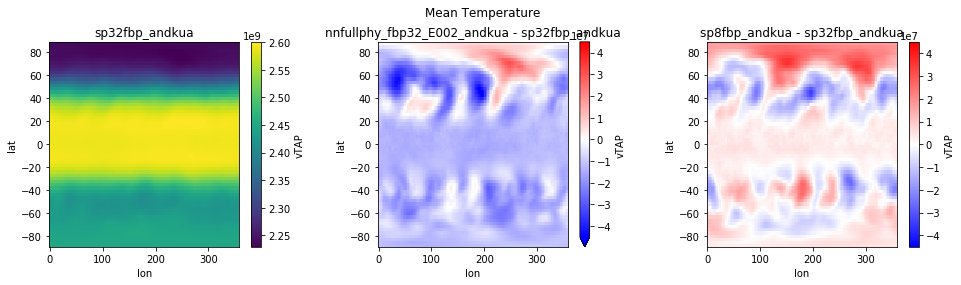

In [311]:
compare(lambda d: d['vTAP'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean Temperature', cmap='bwr', vmin=-4.5e7, vmax=4.5e7)

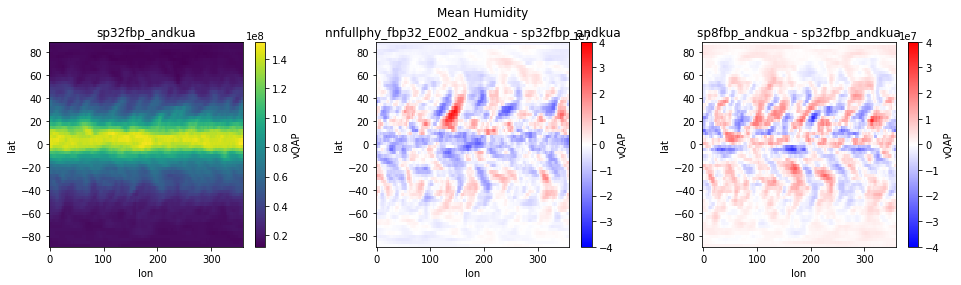

In [312]:
compare(lambda d: d['vQAP'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean Humidity', cmap='bwr', vmin=-4e7, vmax=4e7)

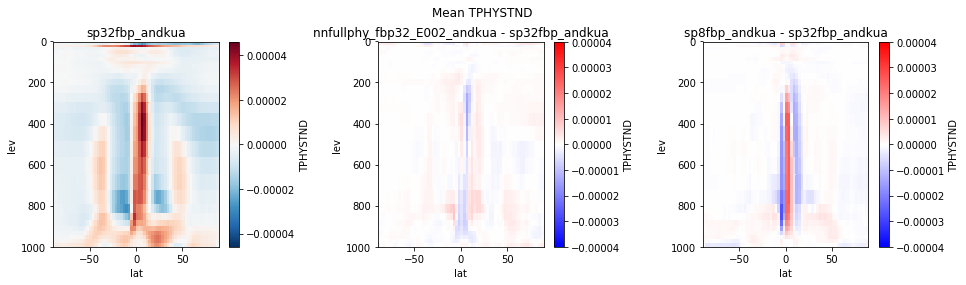

In [313]:
compare(lambda d: d['TPHYSTND'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, cmap='bwr', title='Mean TPHYSTND', vmin=-4e-5, vmax=4e-5)

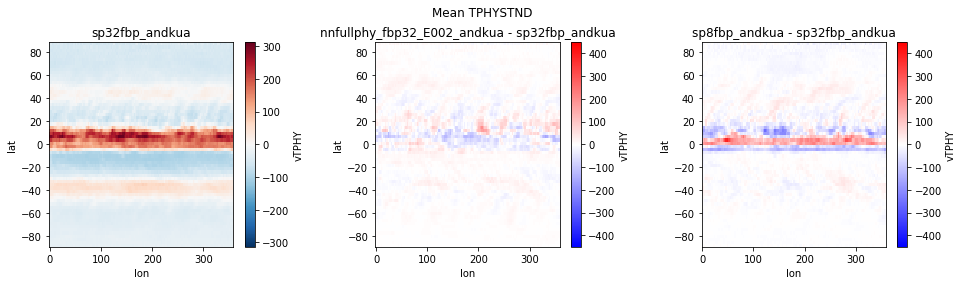

In [314]:
compare(lambda d: d['vTPHY'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean TPHYSTND', cmap='bwr', vmin=-450, vmax=450)

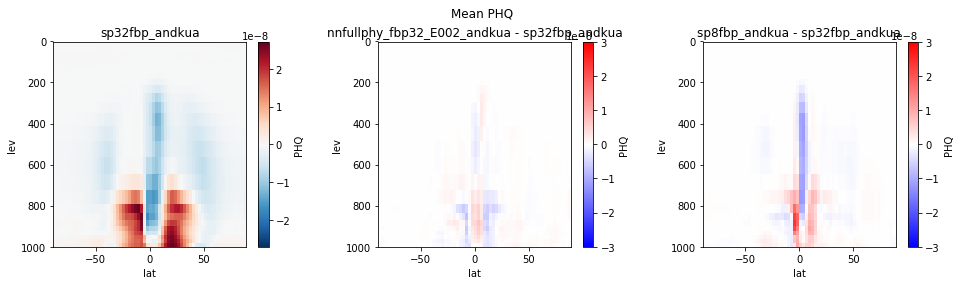

In [315]:
compare(lambda d: d['PHQ'].sel(time=slice(30, None)).mean(('time', 'lon')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        yincrease=False, cmap='bwr', title='Mean PHQ', vmin=-3e-8, vmax=3e-8)

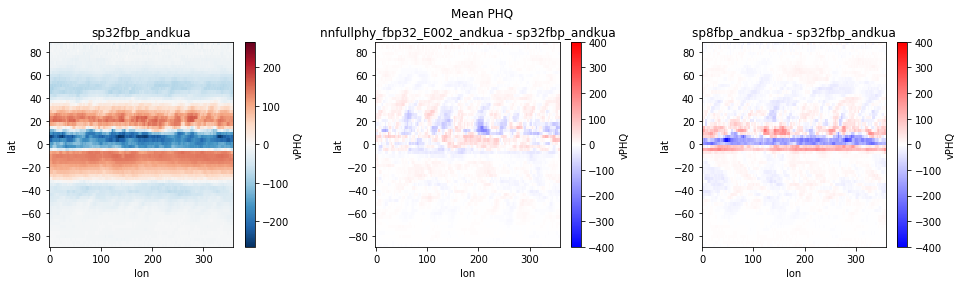

In [316]:
compare(lambda d: d['vPHQ'].sel(time=slice(30, None)).mean(('time')), [exps_32[1], exps_andkua[0]], 
        ref=exps_32[0], 
        title='Mean PHQ', cmap='bwr', vmin=-400, vmax=400)

## More to come

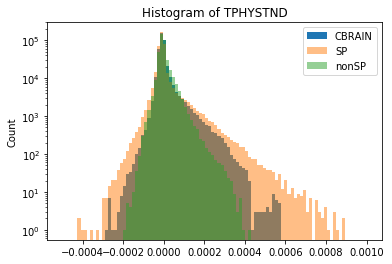

In [42]:
dcbrain['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

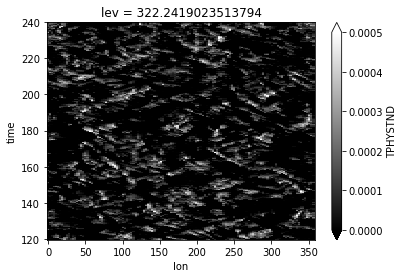

In [130]:
dsp['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(-0, 10)).mean('lat').plot(
    cmap='gray',vmin=0, vmax=0.0005)

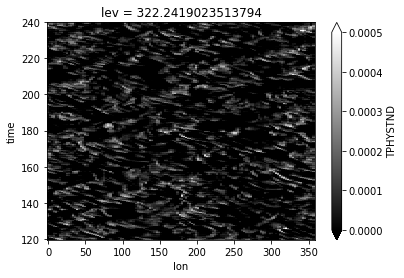

In [131]:
dcbrain['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(-0, 10)).mean('lat').plot(
    cmap='gray',vmin=0, vmax=0.0005)

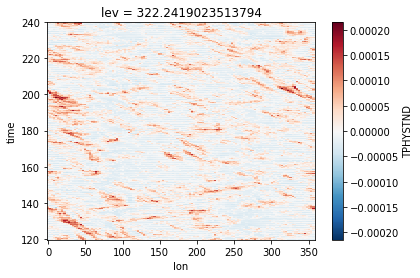

In [127]:
dnonsp['TPHYSTND'].isel(time=slice(120*48, 240*48, 24), lev=15).sel(lat=slice(0, 10)).mean('lat').plot()

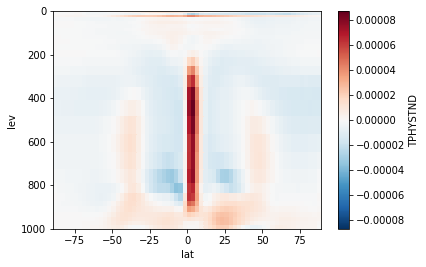

In [121]:
TPHYSTNDmeans[0].mean('lon').plot(yincrease=False)

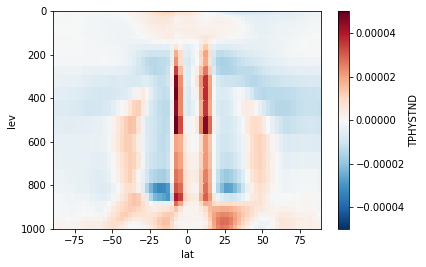

In [128]:
TPHYSTNDmeans[2].mean('lon').plot(yincrease=False)

In [94]:
tmp = xr.open_dataset('/scratch/05488/tg847872/sp8fbp_andkua/sp8fbp_andkua.cam2.h1.0000-01-01-00000.nc',
                     decode_times=False)

In [96]:
tmp.time

<xarray.DataArray 'time' (time: 13)>
array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   , 1.125,
       1.25 , 1.375, 1.5  ])
Coordinates:
  * time     (time) float64 0.0 0.125 0.25 0.375 0.5 0.625 0.75 0.875 1.0 ...
Attributes:
    long_name:  time
    units:      days since 0000-01-01 00:00:00
    calendar:   noleap
    bounds:     time_bnds

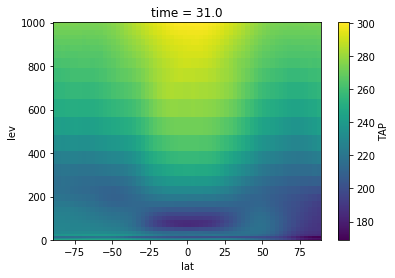

In [91]:
tmp.TAP.mean('lon').plot()